In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

REBUILD_DATA = False

In [2]:
# a kernel - matrix of pixels the CNN takes and simplifies into a feature
# layer 1 - curves, edges
# layer 2 - squares, circles
# layer 3 - combinations of layer 2...

In [3]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = 'PetImages/Cat'
    DOGS = 'PetImages/Dog'
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    # keeping count for balance. Balance is important
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
#                     print(path)
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(f"Cats: {self.catcount}")
        print(f"Dogs: {self.dogcount}")
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
        

In [4]:
training_data = np.load('training_data.npy', allow_pickle=True)

24946


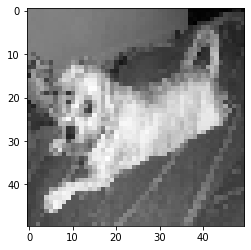

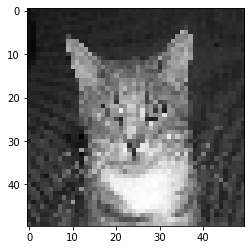

In [5]:
print(len(training_data))
plt.imshow(training_data[1][0], cmap="gray")
plt.show()
plt.imshow(training_data[3][0], cmap="gray")
plt.show()

In [6]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # input, output, and kernel size
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = t.rand(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        
#         print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [7]:
# Run on CPU first
import torch.optim as optim

In [8]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [9]:
X = t.Tensor([i[0] for i in training_data]).view(-1, 50,50)
X = X/255.0
y = t.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [10]:
BATCH_SIZE = 100
EPOCHS = 3

def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            # if the optimizer is controlling all the params, we can zero grad with it
            # if you have 2 optimizers, use the specific network optimizer
            # optimizer.zero_grad()
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
    print(f"Epoch: {epoch}. Loss: {loss}")
# train(net)

In [11]:
def test(net):
    correct = 0
    total = 0

    with t.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = t.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,50,50))[0]
            predicted_class = t.argmax(net_out)

            if predicted_class == real_class:
                correct +=1
            total += 1
    print(f"Accuracy: {round(correct/total,3)}")
# test(net)

In [12]:
if t.cuda.is_available():
    device = t.device("cuda:0")
    print("Running on GPU...")
else:
    device = t.device("cpu")
    print("GPU not found! Reverting to CPU...")
if t.cuda.device_count() > 1:
    print("Congrats. You are serious now")

Running on GPU...


In [13]:
# send whole model to GPU
net_cuda = Net().to(device)
optimizer = optim.Adam(net_cuda.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [18]:
BATCH_SIZE = 1000
EPOCHS = 10

def train(net):
    for epoch in range(EPOCHS):
        for i in range(0, len(train_X), BATCH_SIZE):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")

def test(net):
    correct = 0
    total = 0

    with t.no_grad():
        for i in range(len(test_X)):
            real_class = t.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
            predicted_class = t.argmax(net_out)

            if predicted_class == real_class:
                correct +=1
            total += 1
    print(f"Accuracy: {round(correct/total,3)}")

train(net_cuda)
test(net_cuda)

Epoch: 0. Loss: 0.08506734669208527
Epoch: 1. Loss: 0.08331494778394699
Epoch: 2. Loss: 0.07917947322130203
Epoch: 3. Loss: 0.07489000260829926
Epoch: 4. Loss: 0.09440382570028305
Epoch: 5. Loss: 0.0701233297586441
Epoch: 6. Loss: 0.07632314413785934
Epoch: 7. Loss: 0.08309289813041687
Epoch: 8. Loss: 0.08594623953104019
Epoch: 9. Loss: 0.07208210229873657
Accuracy: 0.773
